In [137]:
import cv2
import numpy as np
import dlib
import imutils 
from matplotlib import pyplot as plt



detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

#print(cv2.__version__)
print(dlib.__version__)
print(cv2.__version__)
print(np.__version__)
print(imutils.__version__)

19.19.0
4.2.0
1.18.4
0.5.3


In [138]:
def get_face_stats(im):
    size = im.shape
    gray  = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    if(len(rects) == 0):
        "no face found"
    for rect in rects:
        face = predictor(gray, rect)
    return get_pose_data(size,face)

In [139]:
def get_pose_data(size, face):
    #print(type(face))
    shape0 = np.array(imutils.face_utils.shape_to_np(face))


    image_points = np.array([
                                (shape0[30, :]),     # Nose tip
                                (shape0[8,  :]),     # Chin
                                (shape0[36, :]),     # Left eye left corner
                                (shape0[45, :]),     # Right eye right corne
                                (shape0[48, :]),     # Left Mouth corner
                                (shape0[54, :])      # Right mouth corner
                            ], dtype="double")

    # 3D model points.
    model_points = np.array([
                                (0.0, 0.0, 0.0),             # Nose tip
                                (0.0, -330.0, -65.0),        # Chin
                                (-225.0, 170.0, -135.0),     # Left eye left corner
                                (225.0, 170.0, -135.0),      # Right eye right corne
                                (-150.0, -150.0, -125.0),    # Left Mouth corner
                                (150.0, -150.0, -125.0)      # Right mouth corner                     
                            ])

    # Camera internals
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )
    print ("Camera Matrix :\n {0}".format(camera_matrix))

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_UPNP)
    print ("Rotation Vector:\n {0}".format(rotation_vector))
    print ("Translation Vector:\n {0}".format(translation_vector))
    return {"im":im,"rotation_vector":rotation_vector,"translation_vector":translation_vector,"camera_matrix":camera_matrix,"dist_coeffs":dist_coeffs, "image_points":image_points}

In [140]:
def draw_pose_from_stats(stats):
    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose
    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), stats["rotation_vector"], stats["translation_vector"], stats["camera_matrix"], stats["dist_coeffs"])
    im = stats["im"]
    image_points = stats["image_points"]
    for p in image_points:
        cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)

    p1 = ( int(image_points[0][0]), int(image_points[0][1]))
    p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

    cv2.line(im, p1, p2, (255,0,0), 2) 
    img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    print(categorize_look(stats))
    plt.imshow(img)
    plt.title('my picture')
    plt.show()

In [141]:
def categorize_look(stats):
    lr = stats["rotation_vector"][2][0]
    print(lr)
    ud = stats["rotation_vector"][1][0]
    lr_boundry = 0.6
    ud_boundry = 0.1
    lr_cat = "centre"
    if(lr > lr_boundry):
        lr_cat = "right"
    elif(lr < (0- lr_boundry)):
        lr_cat = "left"
    ud_cat = "level"
    if(ud > ud_boundry):
        ud_cat = "up"
    elif(ud < (0- lr_boundry)):
        ud_cat = "down"
    return [ud_cat,lr_cat]

In [142]:
def draw_pose(im):
    stats = get_face_stats(im)
    draw_pose_from_stats(stats)

Camera Matrix :
 [[1.08e+03 0.00e+00 5.40e+02]
 [0.00e+00 1.08e+03 3.60e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Rotation Vector:
 [[3.09883941]
 [0.08189339]
 [0.30102425]]
Translation Vector:
 [[-117.3853116 ]
 [-323.95459013]
 [3180.11352133]]
0.30102424855340343
['level', 'centre']


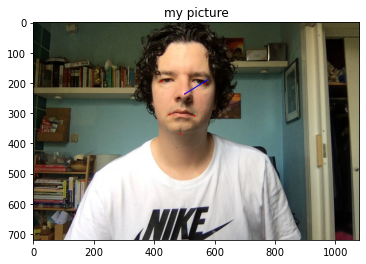

In [143]:
im = cv2.imread("faces/centre.jpg");
draw_pose(im)





Camera Matrix :
 [[1.08e+03 0.00e+00 5.40e+02]
 [0.00e+00 1.08e+03 3.60e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Rotation Vector:
 [[2.81478925]
 [0.13779494]
 [0.01350059]]
Translation Vector:
 [[ -81.85361553]
 [-610.59855207]
 [3543.69749889]]
0.013500593980314217
['up', 'centre']


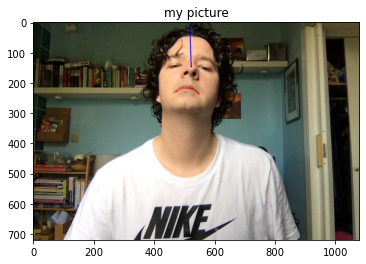

Camera Matrix :
 [[1.08e+03 0.00e+00 5.40e+02]
 [0.00e+00 1.08e+03 3.60e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Rotation Vector:
 [[-2.74984966]
 [-0.14984427]
 [-0.83368464]]
Translation Vector:
 [[ -33.22084057]
 [-107.19381794]
 [2758.37785505]]
-0.8336846435970481
['level', 'left']


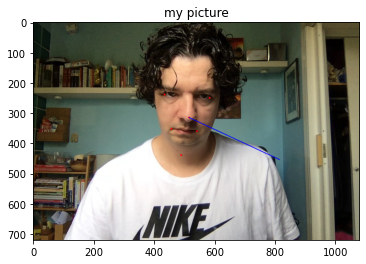

In [144]:
im = cv2.imread("faces/up.jpg");
draw_pose(im)
im = cv2.imread("faces/down.jpg");
draw_pose(im)

Camera Matrix :
 [[1.08e+03 0.00e+00 5.40e+02]
 [0.00e+00 1.08e+03 3.60e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Rotation Vector:
 [[-2.91447087]
 [ 0.07673136]
 [ 0.97716504]]
Translation Vector:
 [[-481.18420972]
 [-313.95696613]
 [3178.72098441]]
0.977165037863125
['level', 'right']


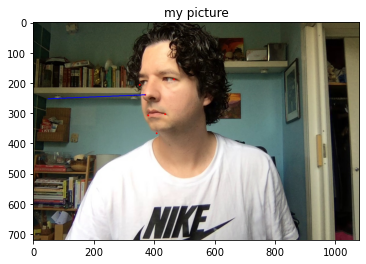

In [145]:
im = cv2.imread("faces/half_right.jpg");
draw_pose(im)


Camera Matrix :
 [[1.08e+03 0.00e+00 5.40e+02]
 [0.00e+00 1.08e+03 3.60e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Rotation Vector:
 [[-2.92937943]
 [-0.1548573 ]
 [-1.02445005]]
Translation Vector:
 [[ 199.81396435]
 [-320.05507442]
 [3123.49724169]]
-1.0244500543051114
['level', 'left']


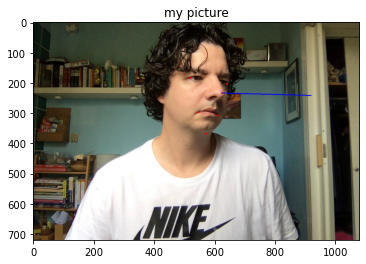

In [146]:
im = cv2.imread("faces/half_left.jpg");
draw_pose(im)


Camera Matrix :
 [[2.394e+03 0.000e+00 1.197e+03]
 [0.000e+00 2.394e+03 1.500e+03]
 [0.000e+00 0.000e+00 1.000e+00]]
Rotation Vector:
 [[-2.63781731]
 [ 0.13787184]
 [-1.10061914]]
Translation Vector:
 [[  187.64741668]
 [-1427.63309647]
 [ 4978.81513772]]
-1.100619135925297
['up', 'left']


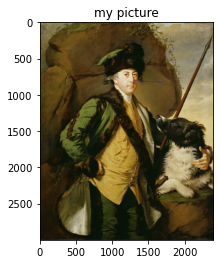

In [147]:
im = cv2.imread("faces/sideface.jpg");
draw_pose(im)


Camera Matrix :
 [[2.394e+03 0.000e+00 1.197e+03]
 [0.000e+00 2.394e+03 1.500e+03]
 [0.000e+00 0.000e+00 1.000e+00]]
Rotation Vector:
 [[-2.57494732]
 [-0.16653315]
 [ 1.04713118]]
Translation Vector:
 [[ -190.96108571]
 [-1427.23587634]
 [ 4983.18647987]]
1.0471311771225094
['level', 'right']


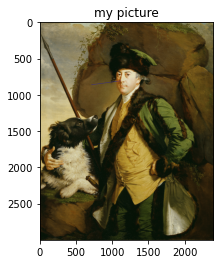

In [148]:
im = cv2.imread("faces/sideface2.jpg");
draw_pose(im)

Camera Matrix :
 [[306.   0. 153.]
 [  0. 306. 219.]
 [  0.   0.   1.]]
Rotation Vector:
 [[-2.75831533]
 [ 0.14548954]
 [ 0.24233284]]
Translation Vector:
 [[ -52.59723941]
 [ -85.84709963]
 [1357.57780907]]
0.24233283771744632
['up', 'centre']


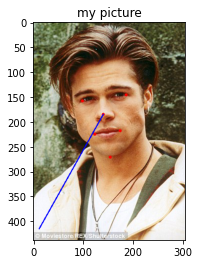

In [149]:
im = cv2.imread("faces/face3.jpg");
draw_pose(im)